## 1. Library

In [1]:
import math
import numpy as np
import pandas as pd
import requests
import io
import zipfile
import os

import cv2

import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical

In [2]:
# Kiểm tra và cấu hình GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [46]:
!nvidia-smi

Tue Nov 19 06:45:00 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P0             30W /   70W |    4321MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Tải dữ liệu

In [3]:
def load_fer2013_from_github():
    """
    Hàm tải và đọc file fer2013.csv từ GitHub
    Returns:
        pandas.DataFrame: DataFrame chứa dữ liệu fer2013
    """
    # Tạo thư mục data nếu chưa tồn tại
    if not os.path.exists('data'):
        os.makedirs('data')
    
    # Đường dẫn đến file csv trong thư mục data
    csv_path = 'data/fer2013.csv'
    
    # Kiểm tra nếu file đã tồn tại
    if os.path.exists(csv_path):
        print("File đã tồn tại trong thư mục data, đang đọc file...")
        return pd.read_csv(csv_path)
    
    try:
        # URL raw của file zip
        raw_url = "https://raw.githubusercontent.com/QuocTrung810/datasets/main/image/fer2013.csv.zip"
        
        # Tải file zip
        print("Đang tải file zip từ GitHub...")
        response = requests.get(raw_url)
        
        if response.status_code == 200:
            # Đọc file zip từ memory
            zip_file = zipfile.ZipFile(io.BytesIO(response.content))
            
            # Giải nén và lưu file csv vào thư mục data
            print("Đang giải nén và lưu file csv...")
            zip_file.extract('fer2013.csv', 'data')
            
            # Đọc file csv
            print("Đang đọc file csv...")
            df = pd.read_csv(csv_path)
            
            print("Đã tải và lưu xong dữ liệu!")
            return df
        else:
            print(f"Lỗi khi tải file: Status code {response.status_code}")
            return None
            
    except Exception as e:
        print(f"Có lỗi xảy ra: {str(e)}")
        return None

In [4]:
# Sử dụng hàm
df = load_fer2013_from_github()

if df is not None:
    print("Shape của dataset:", df.shape)
    print("\nCác cột trong dataset:", df.columns.tolist())
    print("\nThông tin về dataset:")
    print(df.info())

Đang tải file zip từ GitHub...
Đang giải nén và lưu file csv...
Đang đọc file csv...
Đã tải và lưu xong dữ liệu!
Shape của dataset: (35887, 3)

Các cột trong dataset: ['emotion', 'pixels', 'Usage']

Thông tin về dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None


In [5]:
df.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [7]:
emotion_label_to_text = {
    0:'anger', 
    1:'disgust', 
    2:'fear', 
    3:'happiness', 
    4: 'sadness', 
    5: 'surprise', 
    6: 'neutral'
}

In [8]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [9]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

## 3. Visualization

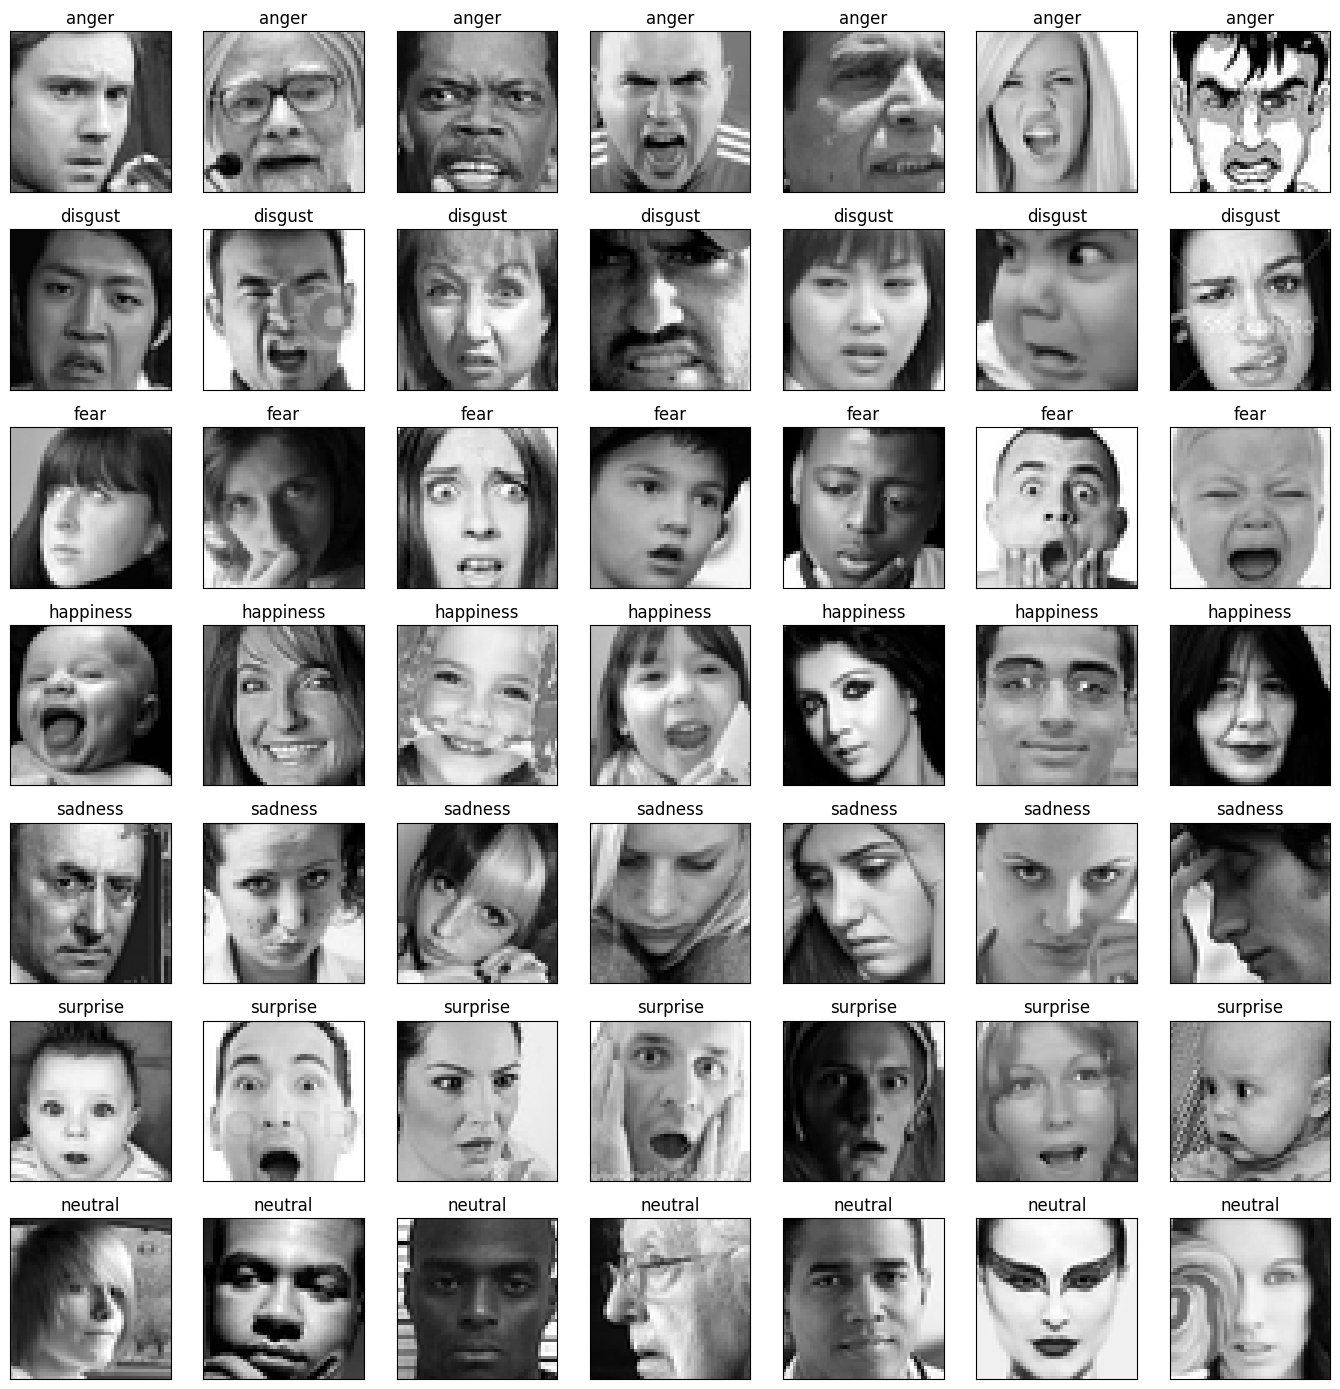

In [10]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

## 4. Data processing

In [11]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [12]:
img_array.shape

(35887, 48, 48)

In [13]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


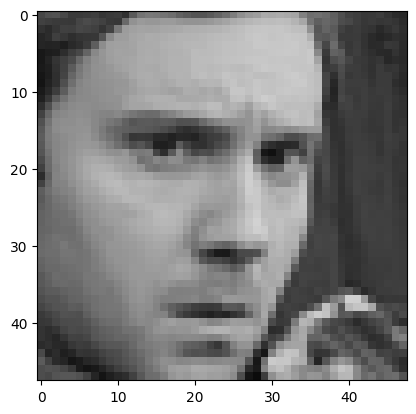

In [14]:
pyplot.imshow(img_features[0].astype(np.uint8));

In [15]:
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [16]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


## 5. Tách dữ liệu thành training và validation set.

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(img_features, 
                                                      img_labels, 
                                                      shuffle = True, 
                                                      stratify = img_labels, 
                                                      test_size = 0.1, 
                                                      random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [18]:
del df
del img_features
del img_labels

In [19]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [20]:
X_train = X_train / 255.
X_valid = X_valid / 255.

## 6. Load pretrained model và fine-tuning model

In [21]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


This code makes all layers of a VGG19 model non-trainable. This allows the model to be applied to a new problem using only pre-learned features, rather than reflecting changes in the training data to the model, while preserving the pre-trained weights. This is a technique often used in transfer learning applications.In particular, while developing a facial emotion recognition model using the VGG19 model, the pre-trained weights of the model are preserved, allowing it to be used in solving a new emotion recognition problem. In this way, it may be possible to obtain better results using less data.

In [22]:
vgg.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
    
    return model

In [24]:
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,027,975 (76.40 MB)

 Trainable params: 20,027,975 (76.40 MB)

 Non-trainable params: 0 (0.00 B)

None


In [25]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

## 7. Tăng cường dữ liệu

In [26]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

## 8. Huấn luyện mô hình

In [27]:
# batch size of 32 performs the best.
batch_size = 32 
epochs = 25
optims = [optimizers.Adam(learning_rate = 0.0001, 
                          beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [28]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

# batch size of 32 performs the best.
batch_size = 32 
epochs = 30
optims = [optimizers.Adam(learning_rate = 0.0001, 
                          beta_1 = 0.9, beta_2 = 0.999),]

steps_per_epoch = len(X_train) // batch_size

train_generator = train_datagen.flow(X_train, 
                                   y_train,
                                   batch_size=batch_size,
                                   shuffle=True)

optims = [optimizers.Adam(learning_rate=0.0001,
                         beta_1=0.9, beta_2=0.999)]

model.compile(loss='categorical_crossentropy',
             optimizer=optims[0],
             metrics=['accuracy'])

history = model.fit(train_generator,
                   validation_data=(X_valid, y_valid),
                   steps_per_epoch=steps_per_epoch,
                   epochs=epochs,
                   callbacks=callbacks)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731994845.680208     111 service.cc:145] XLA service 0x7d1990002900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731994845.680284     111 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731994845.680290     111 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   3/1009 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - accuracy: 0.1476 - loss: 1.9840 

I0000 00:00:1731994852.715024     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 71s 60ms/step - accuracy: 0.3416 - loss: 1.6374 - val_accuracy: 0.5082 - val_loss: 1.2955 - learning_rate: 1.0000e-04
Epoch 2/30
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.5938 - loss: 1.1398

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5938 - loss: 1.1398 - val_accuracy: 0.5040 - val_loss: 1.3228 - learning_rate: 1.0000e-04
Epoch 3/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 58s 57ms/step - accuracy: 0.5069 - loss: 1.2759 - val_accuracy: 0.5564 - val_loss: 1.1886 - learning_rate: 1.0000e-04
Epoch 4/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5312 - loss: 1.1112 - val_accuracy: 0.5534 - val_loss: 1.1806 - learning_rate: 1.0000e-04
Epoch 5/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 60s 59ms/step - accuracy: 0.5539 - loss: 1.1705 - val_accuracy: 0.5857 - val_loss: 1.1276 - learning_rate: 1.0000e-04
Epoch 6/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5938 - loss: 1.2261 - val_accuracy: 0.5952 - val_loss: 1.1053 - learning_rate: 1.0000e-04
Epoch 7/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 60s 59ms/step - accuracy: 0.5840 - loss: 1.1054 - val_accuracy: 0.5901 - val_loss: 1.0851 - learning_rate: 1.0000e-04
Epoch 8/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - a

## 9. Lưu mô hình

In [29]:
model_yaml = model.to_json()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

## 10. Đánh giá mô hình

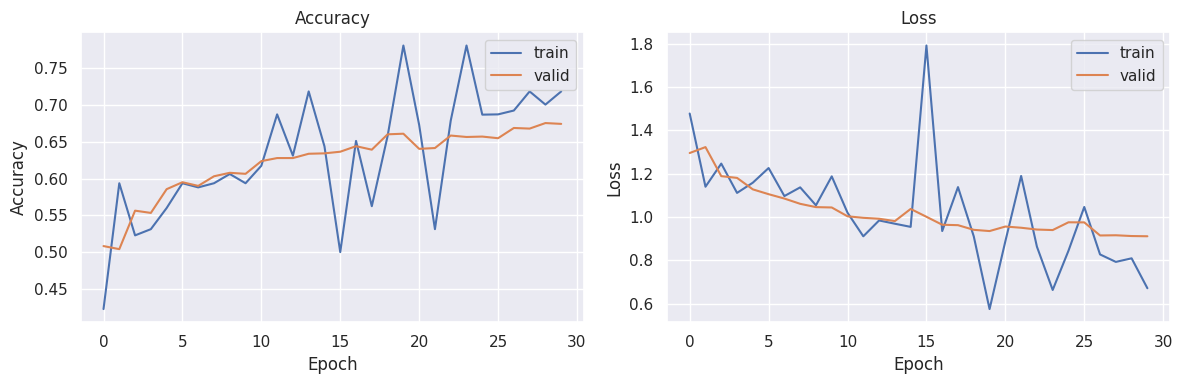

In [37]:
# Tạo figure với kích thước cố định
pyplot.figure(figsize=(12, 4))

# Vẽ biểu đồ Accuracy
pyplot.subplot(1, 2, 1)
pyplot.plot(history.epoch, history.history['accuracy'], label='train')
pyplot.plot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.legend()
pyplot.grid(True)

# Vẽ biểu đồ Loss
pyplot.subplot(1, 2, 2)
pyplot.plot(history.epoch, history.history['loss'], label='train')
pyplot.plot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.grid(True)

# Điều chỉnh layout
pyplot.tight_layout()

# Lưu và hiển thị
pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()


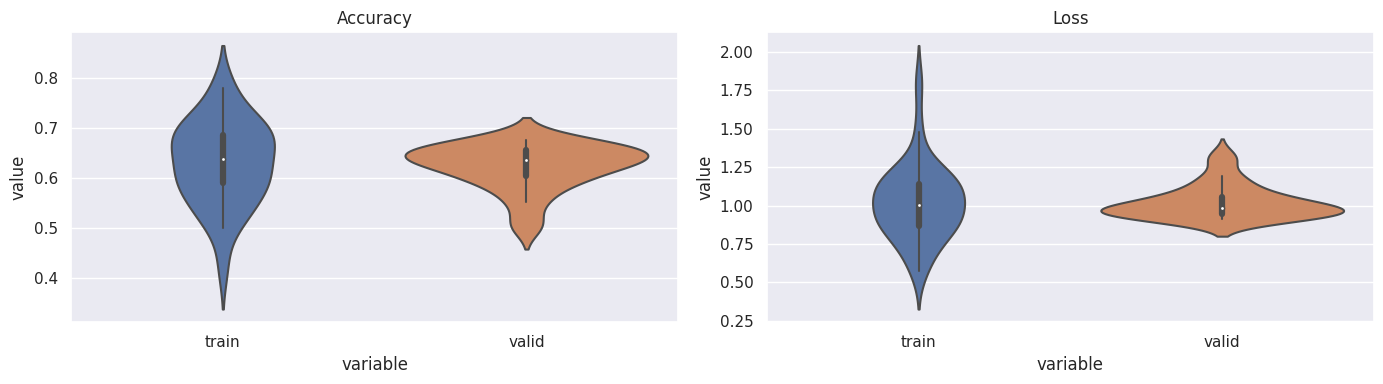

In [31]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


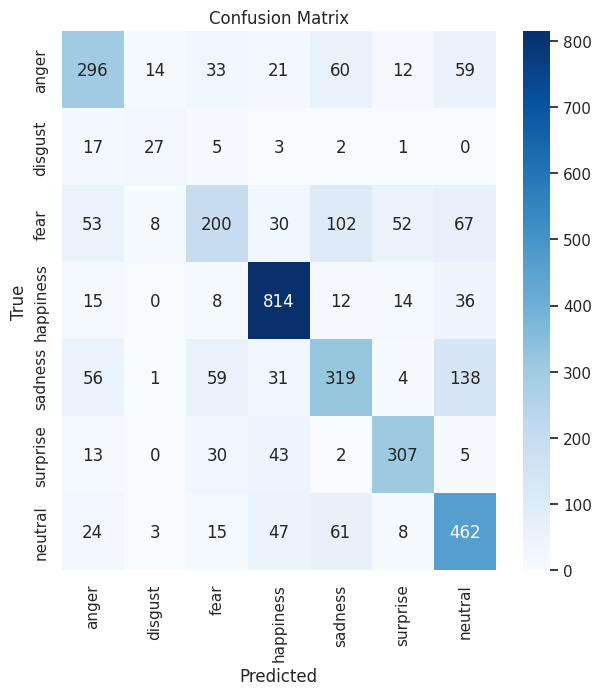

total wrong validation predictions: 1164


              precision    recall  f1-score   support

           0       0.62      0.60      0.61       495
           1       0.51      0.49      0.50        55
           2       0.57      0.39      0.46       512
           3       0.82      0.91      0.86       899
           4       0.57      0.52      0.55       608
           5       0.77      0.77      0.77       400
           6       0.60      0.75      0.67       620

    accuracy                           0.68      3589
   macro avg       0.64      0.63      0.63      3589
weighted avg       0.67      0.68      0.67      3589



In [32]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
y_true = np.argmax(y_valid, axis=1)

# Tính confusion matrix
cm = confusion_matrix(y_true, yhat_valid)

# Vẽ confusion matrix
pyplot.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral'],
            yticklabels=['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral'])
pyplot.title('Confusion Matrix')
pyplot.xlabel('Predicted')
pyplot.ylabel('True')
pyplot.savefig("confusion_matrix_dcnn.png")
pyplot.show()

print(f'total wrong validation predictions: {np.sum(y_true != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [33]:
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


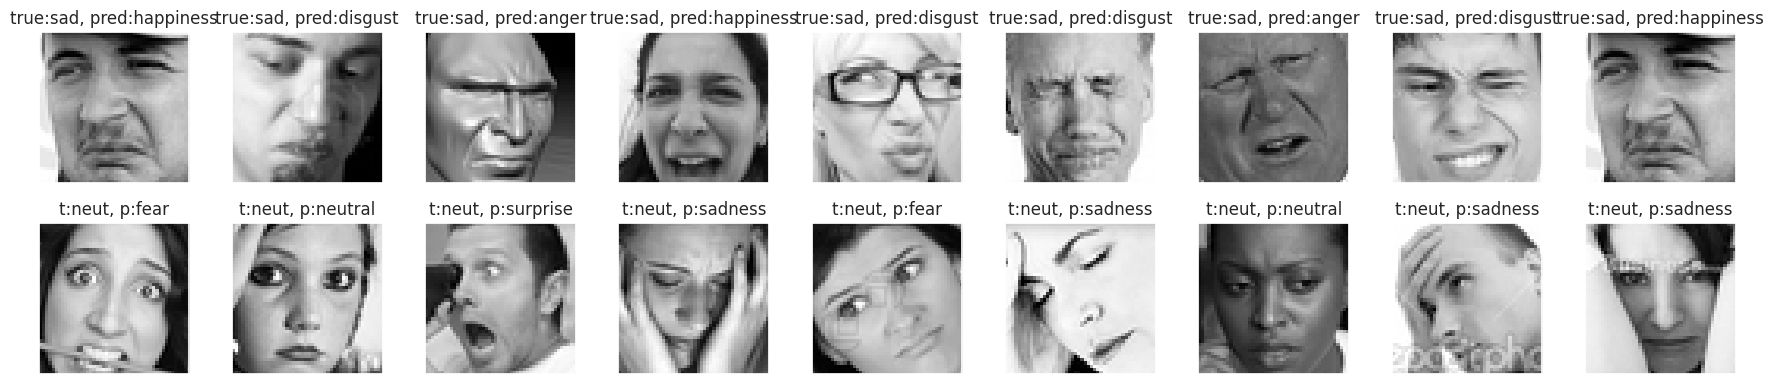

In [34]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

        ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)
        
        ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        pyplot.tight_layout()

## 11. Dự đoán cảm xúc bằng webcam

In [35]:
def realtime_emotion_detection():
    # Load model đã train
    from tensorflow.keras.models import load_model
    model = load_model('model.h5')
    
    # Load face cascade classifier của OpenCV
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Định nghĩa map emotion
    emotion_dict = {
        0: 'Angry',
        1: 'Disgust',
        2: 'Fear',
        3: 'Happy',
        4: 'Sad',
        5: 'Surprise',
        6: 'Neutral'
    }
    
    # Khởi tạo webcam
    cap = cv2.VideoCapture(0)
    
    while True:
        # Đọc frame từ webcam
        ret, frame = cap.read()
        if not ret:
            break
            
        # Chuyển sang ảnh xám để detect face
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Detect faces
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        
        # Xử lý từng khuôn mặt detect được
        for (x, y, w, h) in faces:
            # Vẽ rectangle xung quanh mặt
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
            
            # Cắt vùng mặt
            roi_gray = gray[y:y + h, x:x + w]
            roi_color = frame[y:y + h, x:x + w]
            
            # Resize về kích thước 48x48 như data training
            roi_gray = cv2.resize(roi_gray, (48, 48))
            
            # Chuẩn bị ảnh cho prediction
            roi_gray = cv2.cvtColor(cv2.resize(roi_gray, (48, 48)), cv2.COLOR_GRAY2RGB)
            roi_gray = roi_gray.astype('float') / 255.0
            roi_gray = np.expand_dims(roi_gray, axis=0)
            
            # Dự đoán emotion
            prediction = model.predict(roi_gray)
            maxindex = int(np.argmax(prediction))
            
            # Hiển thị kết quả
            emotion = emotion_dict[maxindex]
            cv2.putText(frame, emotion, (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
            
            # Hiển thị confidence score
            confidence = round(np.max(prediction) * 100, 2)
            confidence_text = f'{confidence}%'
            cv2.putText(frame, confidence_text, (x+w-70, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2, cv2.LINE_AA)
        
        # Hiển thị frame
        cv2.imshow('Emotion Detection', frame)
        
        # Nhấn 'q' để thoát
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Giải phóng resources
    cap.release()
    cv2.destroyAllWindows()

In [43]:
# realtime_emotion_detection()

## 12. Dự đoán cảm xúc bằng ảnh

In [38]:
def emotion_detection_image(image_path):
    # Load model đã train
    from tensorflow.keras.models import load_model
    import cv2
    import numpy as np
    
    model = load_model('model.h5')
    
    # Load face cascade classifier của OpenCV
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Định nghĩa map emotion
    emotion_dict = {
        0: 'Angry',
        1: 'Disgust',
        2: 'Fear',
        3: 'Happy',
        4: 'Sad',
        5: 'Surprise',
        6: 'Neutral'
    }
    
    # Đọc ảnh
    frame = cv2.imread(image_path)
    if frame is None:
        print("Không thể đọc ảnh!")
        return
            
    # Chuyển sang ảnh xám để detect face
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    # Xử lý từng khuôn mặt detect được
    for (x, y, w, h) in faces:
        # Vẽ rectangle xung quanh mặt
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Cắt vùng mặt
        roi_gray = gray[y:y + h, x:x + w]
        
        # Resize về kích thước 48x48 như data training
        roi_gray = cv2.resize(roi_gray, (48, 48))
        
        # Chuẩn bị ảnh cho prediction
        roi_gray = cv2.cvtColor(cv2.resize(roi_gray, (48, 48)), cv2.COLOR_GRAY2RGB)
        roi_gray = roi_gray.astype('float') / 255.0
        roi_gray = np.expand_dims(roi_gray, axis=0)
        
        # Dự đoán emotion
        prediction = model.predict(roi_gray)
        maxindex = int(np.argmax(prediction))
        
        # Hiển thị kết quả
        emotion = emotion_dict[maxindex]
        cv2.putText(frame, emotion, (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
        
        # Hiển thị confidence score
        confidence = round(np.max(prediction) * 100, 2)
        confidence_text = f'{confidence}%'
        cv2.putText(frame, confidence_text, (x+w-70, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2, cv2.LINE_AA)
    
    # Lưu kết quả
    output_path = 'emotion_detection_result.jpg'
    cv2.imwrite(output_path, frame)
    
    # Hiển thị ảnh kết quả sử dụng matplotlib
    from matplotlib import pyplot as plt
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [39]:
# Sử dụng hàm với một ảnh
emotion_detection_image('https://i.pinimg.com/236x/2f/9d/41/2f9d41b5c2b35545d97deff826d052cc.jpg')

Không thể đọc ảnh!


[ WARN:0@1279.867] global loadsave.cpp:241 findDecoder imread_('https://i.pinimg.com/236x/2f/9d/41/2f9d41b5c2b35545d97deff826d052cc.jpg'): can't open/read file: check file path/integrity


## 13. Dự đoán cảm xúc bằng url

In [40]:
def emotion_detection_from_url(image_url):
    # Import các thư viện cần thiết
    from tensorflow.keras.models import load_model
    import cv2
    import numpy as np
    import urllib.request
    
    # Đọc ảnh từ URL
    req = urllib.request.urlopen(image_url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    frame = cv2.imdecode(arr, -1) # 'Load it as it is'
    
    # Load model đã train
    model = load_model('model.h5')
    
    # Load face cascade classifier của OpenCV
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Định nghĩa map emotion
    emotion_dict = {
        0: 'Angry',
        1: 'Disgust',
        2: 'Fear',
        3: 'Happy',
        4: 'Sad',
        5: 'Surprise',
        6: 'Neutral'
    }
    
    if frame is None:
        print("Không thể đọc ảnh từ URL!")
        return
            
    # Chuyển sang ảnh xám để detect face
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    # Xử lý từng khuôn mặt detect được
    for (x, y, w, h) in faces:
        # Vẽ rectangle xung quanh mặt
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Cắt vùng mặt
        roi_gray = gray[y:y + h, x:x + w]
        
        # Resize về kích thước 48x48 như data training
        roi_gray = cv2.resize(roi_gray, (48, 48))
        
        # Chuẩn bị ảnh cho prediction
        roi_gray = cv2.cvtColor(cv2.resize(roi_gray, (48, 48)), cv2.COLOR_GRAY2RGB)
        roi_gray = roi_gray.astype('float') / 255.0
        roi_gray = np.expand_dims(roi_gray, axis=0)
        
        # Dự đoán emotion
        prediction = model.predict(roi_gray)
        maxindex = int(np.argmax(prediction))
        
        # Hiển thị kết quả
        emotion = emotion_dict[maxindex]
        cv2.putText(frame, emotion, (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
        
        # Hiển thị confidence score
        confidence = round(np.max(prediction) * 100, 2)
        confidence_text = f'{confidence}%'
        cv2.putText(frame, confidence_text, (x+w-70, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2, cv2.LINE_AA)
    
    # Lưu kết quả
    output_path = 'emotion_detection_result.jpg'
    cv2.imwrite(output_path, frame)
    
    # Hiển thị ảnh kết quả sử dụng matplotlib
    from matplotlib import pyplot as plt
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


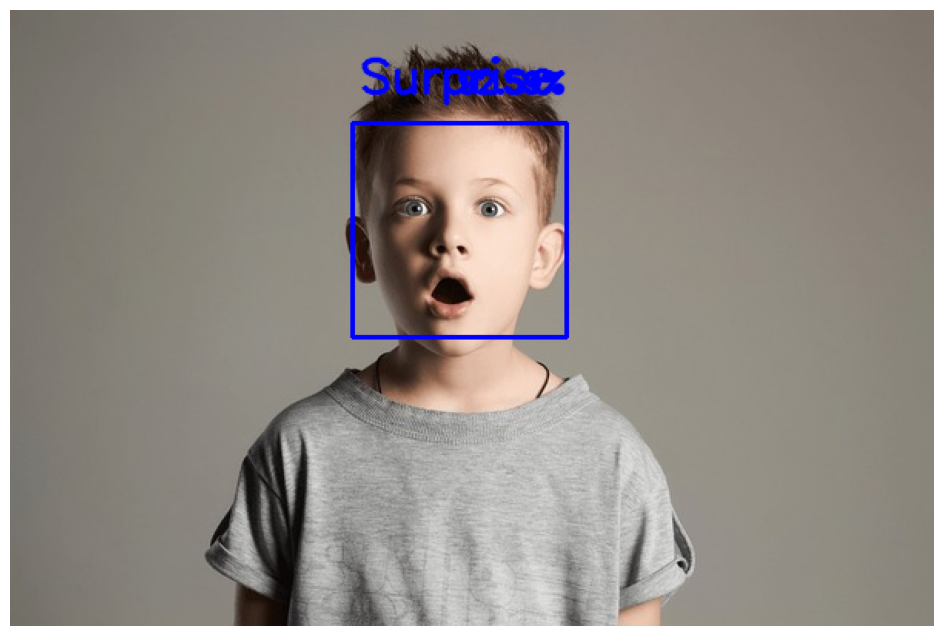

In [42]:
# Sử dụng hàm với URL ảnh
image_url = "https://www.shutterstock.com/image-photo/funny-kidhandsome-little-boysurprised-7-600nw-614016944.jpg"
emotion_detection_from_url(image_url)

In [45]:
!zip -r /kaggle/working/all_files.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/epoch_history_dcnn.png (deflated 5%)
  adding: kaggle/working/model.yaml (deflated 94%)
  adding: kaggle/working/data/ (stored 0%)
  adding: kaggle/working/data/fer2013.csv (deflated 68%)
  adding: kaggle/working/emotion_detection_result.jpg (deflated 2%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/confusion_matrix_dcnn.png (deflated 8%)
  adding: kaggle/working/model.h5 (deflated 12%)
  adding: kaggle/working/performance_dist.png (deflated 6%)
